In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np


In [2]:
df = pd.read_csv("Data/final_clean_data.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45155 entries, 0 to 45154
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MONTH                      45155 non-null  int64  
 1   DAY_OF_MONTH               45155 non-null  int64  
 2   DAY_OF_WEEK                45155 non-null  int64  
 3   OP_UNIQUE_CARRIER          45155 non-null  object 
 4   ORIGIN                     45155 non-null  object 
 5   ORIGIN_STATE_ABR           45155 non-null  object 
 6   DEST                       45155 non-null  object 
 7   DEST_STATE_ABR             45155 non-null  object 
 8   CRS_DEP_TIME               45155 non-null  float64
 9   DEP_DELAY                  45155 non-null  float64
 10  DEP_DELAY_NEW              45155 non-null  float64
 11  DEP_DEL15                  45155 non-null  float64
 12  DEP_DELAY_GROUP            45155 non-null  float64
 13  CRS_ARR_TIME               45155 non-null  flo

### Route-Specific Patterns (By Flight Route)

In [3]:
df["ORIGIN-DEST"] = df["ORIGIN"] + "-" + df["DEST"]

route_delay_stats = (
    df.groupby("ORIGIN-DEST")
    .agg(
        NUM_FLIGHTS=("DEP_DELAY", "count"),       
        AVG_DEP_DELAY=("DEP_DELAY", "mean"),       
        PCT_DELAYED_15=("DEP_DEL15", "mean"),      
        NUM_DELAYED=("DEP_DEL15", "sum")           
    )
    .reset_index()
)

top10_routes = route_delay_stats.sort_values(by="NUM_FLIGHTS", ascending=False).head(10)
print(top10_routes)

    ORIGIN-DEST  NUM_FLIGHTS  AVG_DEP_DELAY  PCT_DELAYED_15  NUM_DELAYED
102     SEA-PHX         1767      -0.188455        0.114884        203.0
81      SEA-LAX         1712      -0.954439        0.105140        180.0
42      SEA-ANC         1673       3.239091        0.164973        276.0
115     SEA-SFO         1575       0.178413        0.125714        198.0
80      SEA-LAS         1407       0.757640        0.133618        188.0
59      SEA-DEN         1386       1.134921        0.134921        187.0
99      SEA-ORD         1374      -0.319505        0.107715        148.0
22      GEG-SEA         1239      -3.098467        0.087974        109.0
67      SEA-GEG         1196       0.392140        0.120401        144.0
60      SEA-DFW         1155       1.149784        0.141126        163.0


#### Top 10 Flight Routes with Highest Delay Percentage

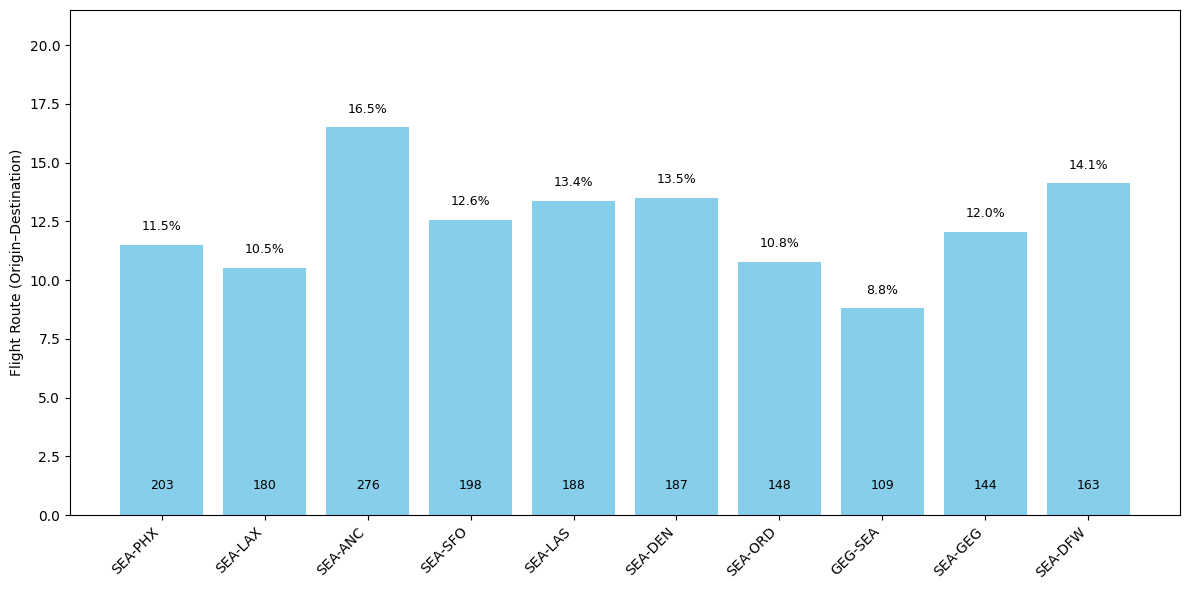

In [4]:
plt.figure(figsize=(12,6))
bars = plt.bar(top10_routes["ORIGIN-DEST"], 
               top10_routes["PCT_DELAYED_15"]*100, 
               color="skyblue")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Flight Route (Origin–Destination)")

for bar, pct in zip(bars, top10_routes["PCT_DELAYED_15"]*100):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height()+0.5,
             f"{pct:.1f}%", 
             ha="center", va="bottom", fontsize=9)

for bar, n in zip(bars, top10_routes["NUM_DELAYED"]):
    plt.text(bar.get_x() + bar.get_width()/2, 
             1, 
             f"{int(n)}", 
             ha="center", va="bottom", fontsize=9, color="black")
    
max_pct = (top10_routes["PCT_DELAYED_15"]*100).max()
plt.ylim(0, max_pct + 5)

plt.tight_layout()
plt.show()

#### Top 10 Flight Routes with Highest Average Departure Delay

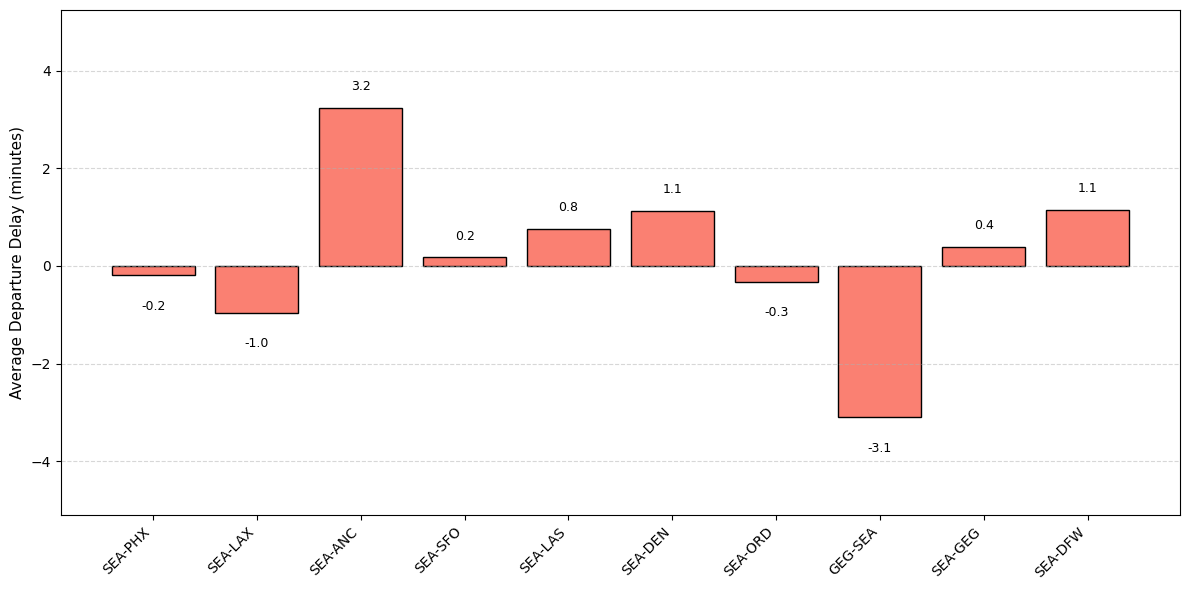

In [5]:
plt.figure(figsize=(12, 6))

bars = plt.bar(
    top10_routes["ORIGIN-DEST"],
    top10_routes["AVG_DEP_DELAY"],
    color="salmon",
    edgecolor="black"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Departure Delay (minutes)", fontsize=11)

for bar, val in zip(bars, top10_routes["AVG_DEP_DELAY"]):
    ha = "center"
    va = "bottom" if val >= 0 else "top"
    offset = 0.3 if val >= 0 else -0.5
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + offset,
        f"{val:.1f}",
        ha=ha, va=va, fontsize=9, color="black"
    )

ymin, ymax = top10_routes["AVG_DEP_DELAY"].min(), top10_routes["AVG_DEP_DELAY"].max()
plt.ylim(ymin - 2, ymax + 2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Chắc bỏ thôi

### Time-of-Day Effect

#### Daily Flight Delays (Over 15 Minutes) by Month

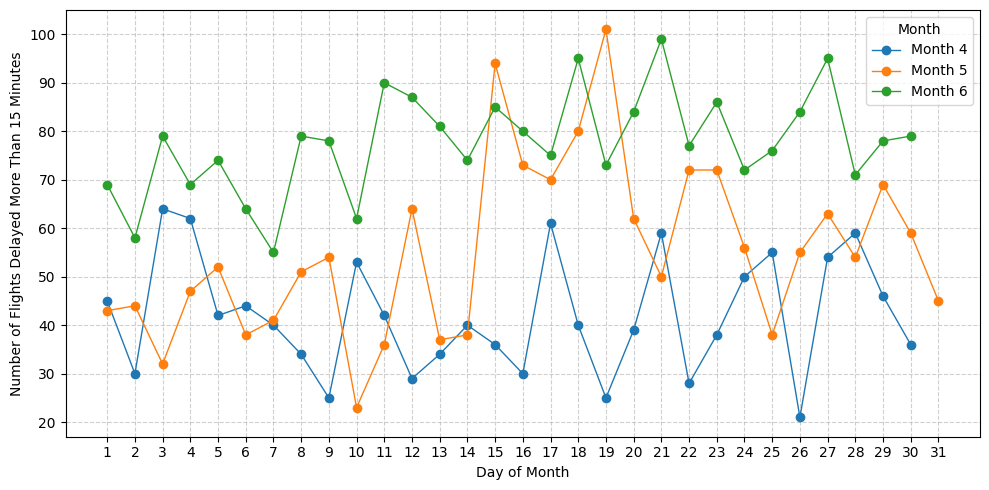

In [6]:
daily_delays = (
    df.groupby(["MONTH", "DAY_OF_MONTH"])["DEP_DEL15"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10,5))
for month, data in daily_delays.groupby("MONTH"):
    plt.plot(data["DAY_OF_MONTH"], data["DEP_DEL15"], 
             marker="o", linestyle="-", linewidth=1, label=f"Month {month}")

plt.xticks(range(1, daily_delays["DAY_OF_MONTH"].max()+1))
plt.xlabel("Day of Month")
plt.ylabel("Number of Flights Delayed More Than 15 Minutes")
plt.legend(title="Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
# Convert float (decimal hour) to hh:mm format
def float_to_hhmm(x):
    hour = int(x)
    minute = int(round((x - hour)*60))
    if minute == 60:  
        hour += 1
        minute = 0
    return f"{hour:02d}:{minute:02d}"

#### Average Departure Delay by Scheduled Departure Time for month

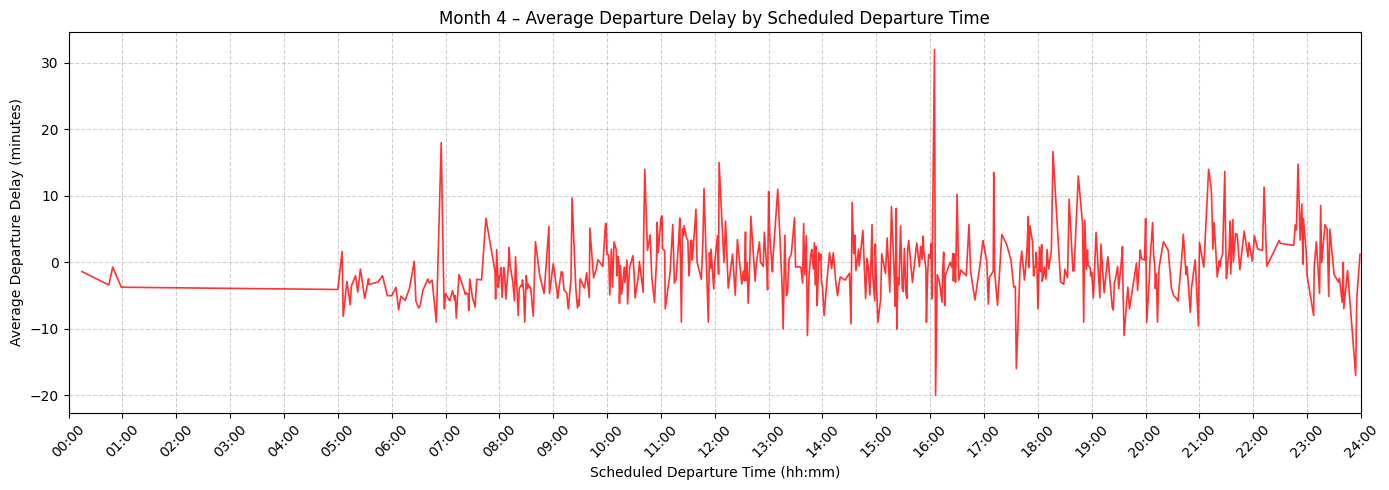

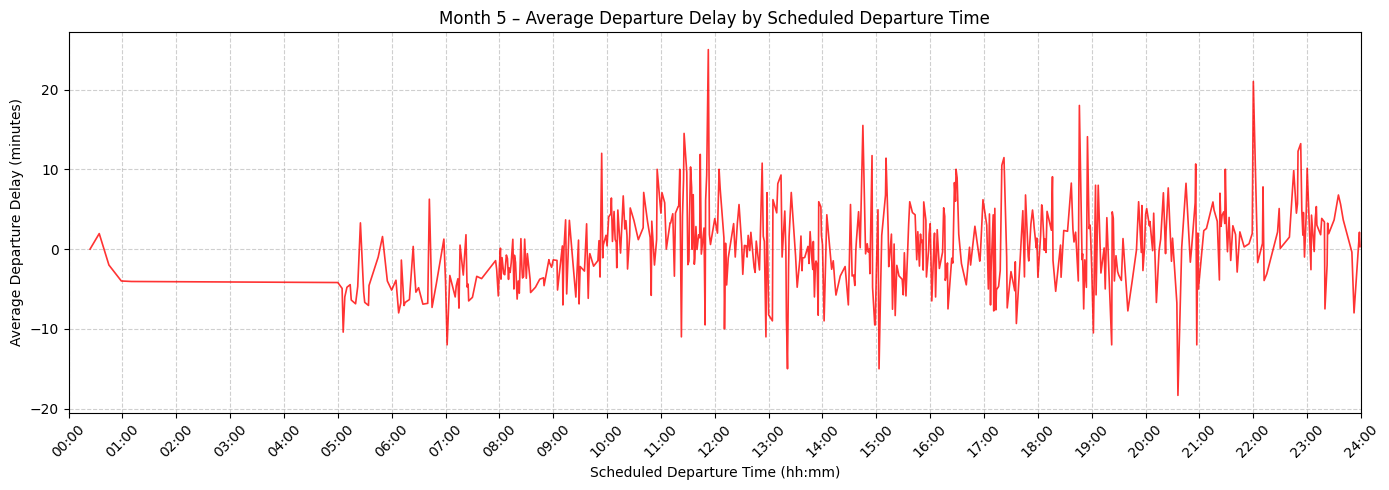

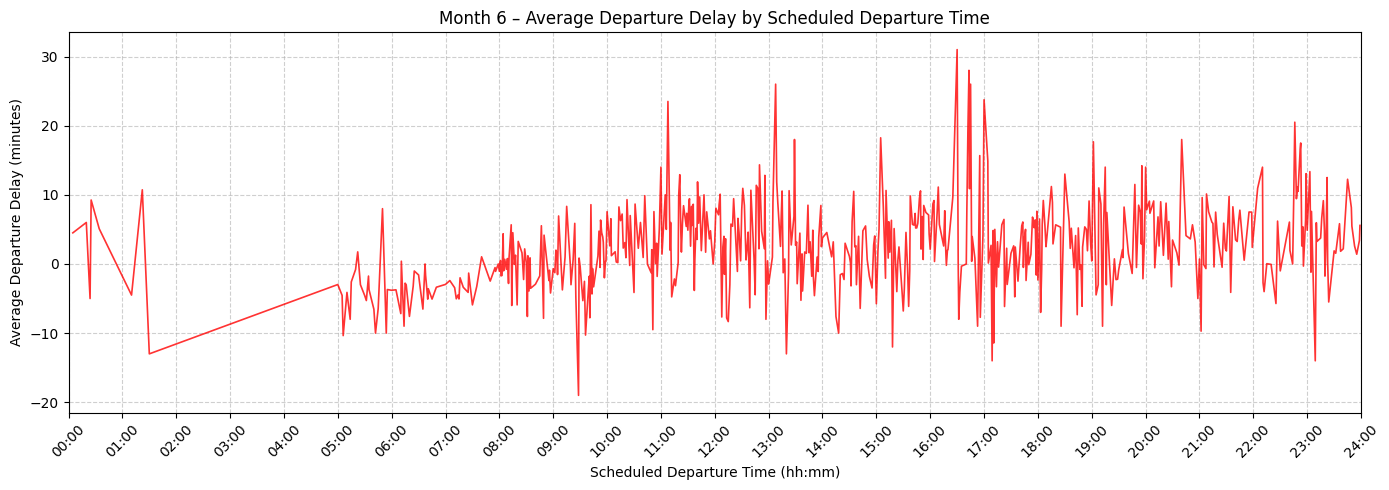

In [8]:
df["DEP_HOUR_MIN"] = df["CRS_DEP_TIME"].astype(float)

for month in sorted(df["MONTH"].unique()):
    time_delays = (
        df[df["MONTH"]==month]
        .groupby("DEP_HOUR_MIN")["DEP_DELAY"]
        .mean()
        .reset_index()
    )
    
    plt.figure(figsize=(14,5))
    plt.plot(
        time_delays["DEP_HOUR_MIN"],
        time_delays["DEP_DELAY"],
        color="red",
        linewidth=1.2,
        alpha=0.8
    )
    
    # Trục X từ 0h–24h
    x_ticks = np.arange(0,25,1)
    plt.xticks(x_ticks, [float_to_hhmm(x) for x in x_ticks], rotation=45)
    
    plt.xlim(0,24)
    plt.xlabel("Scheduled Departure Time (hh:mm)")
    plt.ylabel("Average Departure Delay (minutes)")
    plt.title(f"Month {month} – Average Departure Delay by Scheduled Departure Time")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Day-of-Week Effect on Flight Delays (Over 15 Minutes)

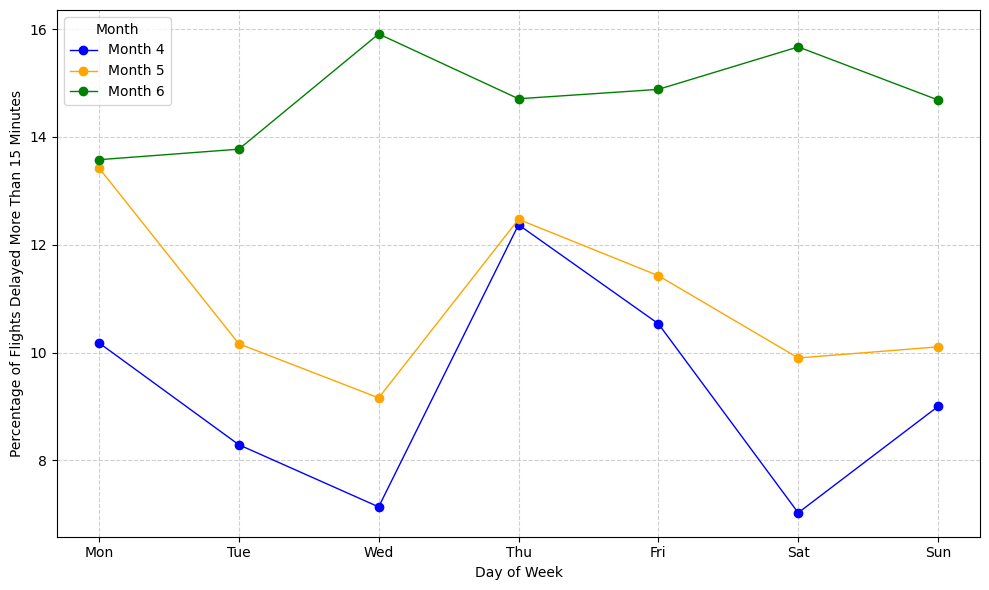

In [9]:
day_map = {1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun"}
df["DAY_NAME"] = df["DAY_OF_WEEK"].map(day_map)

dow_delays = (
    df.groupby(["MONTH","DAY_NAME"])["DEP_DEL15"]
    .mean()
    .reset_index()
)

dow_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

plt.figure(figsize=(10,6))
colors = {4:"blue", 5:"orange", 6:"green"}
for month in sorted(df["MONTH"].unique()):
    data = (
        dow_delays[dow_delays["MONTH"]==month]
        .set_index("DAY_NAME")
        .reindex(dow_order)
        .reset_index()
    )
    plt.plot(data["DAY_NAME"], data["DEP_DEL15"]*100,
             marker="o", linewidth=1, color=colors[month], label=f"Month {month}")

plt.xlabel("Day of Week")
plt.ylabel("Percentage of Flights Delayed More Than 15 Minutes")
plt.legend(title="Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Average Departure Delay by Scheduled Departure Time (SEA–ANC vs SEA–DFW)

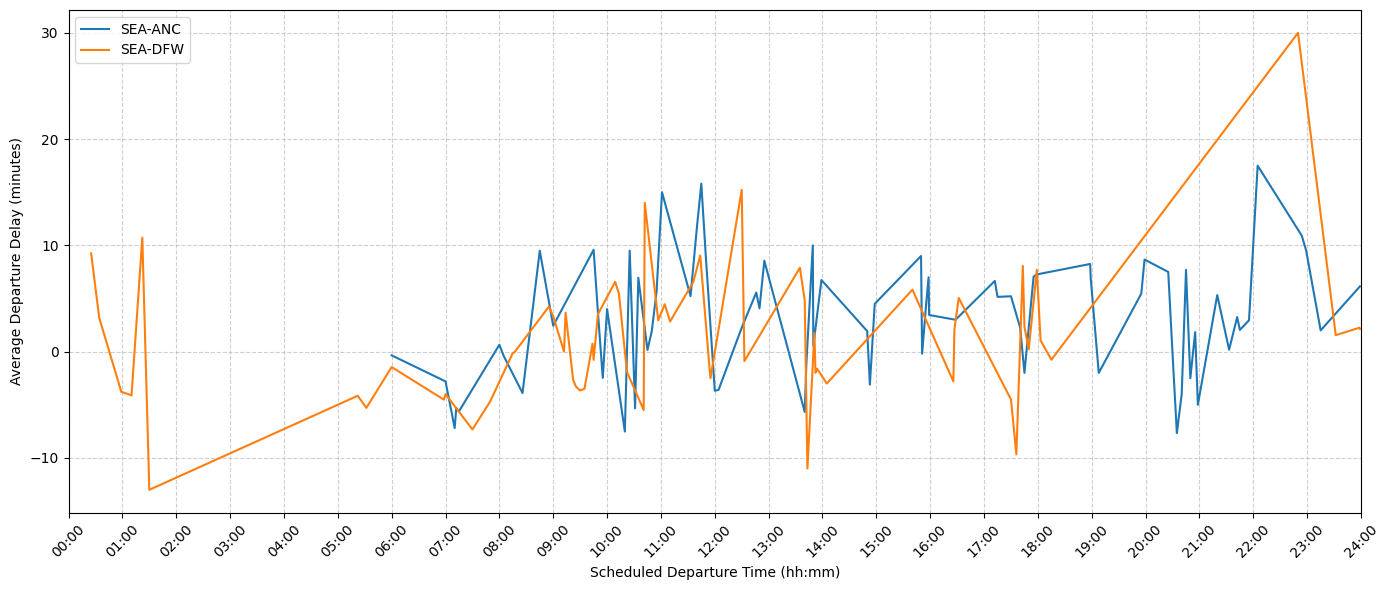

In [10]:
routes = ["SEA-ANC", "SEA-DFW"]

plt.figure(figsize=(14,6))
for route in routes:
    temp = df[df["ORIGIN-DEST"] == route].copy()
    temp["DEP_HOUR_MIN"] = temp["CRS_DEP_TIME"].astype(float)
    
    hourly = temp.groupby("DEP_HOUR_MIN")["DEP_DELAY"].mean().reset_index()
    
    plt.plot(hourly["DEP_HOUR_MIN"], hourly["DEP_DELAY"], 
             linewidth=1.5, label=route)

# X-axis from 00:00 to 24:00
x_ticks = np.arange(0,25,1)
plt.xticks(x_ticks, [float_to_hhmm(x) for x in x_ticks], rotation=45)

plt.xlim(0,24)
plt.xlabel("Scheduled Departure Time (hh:mm)")
plt.ylabel("Average Departure Delay (minutes)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



#### Day-of-Week Effect on Flight Delays (SEA–ANC vs SEA–DFW)

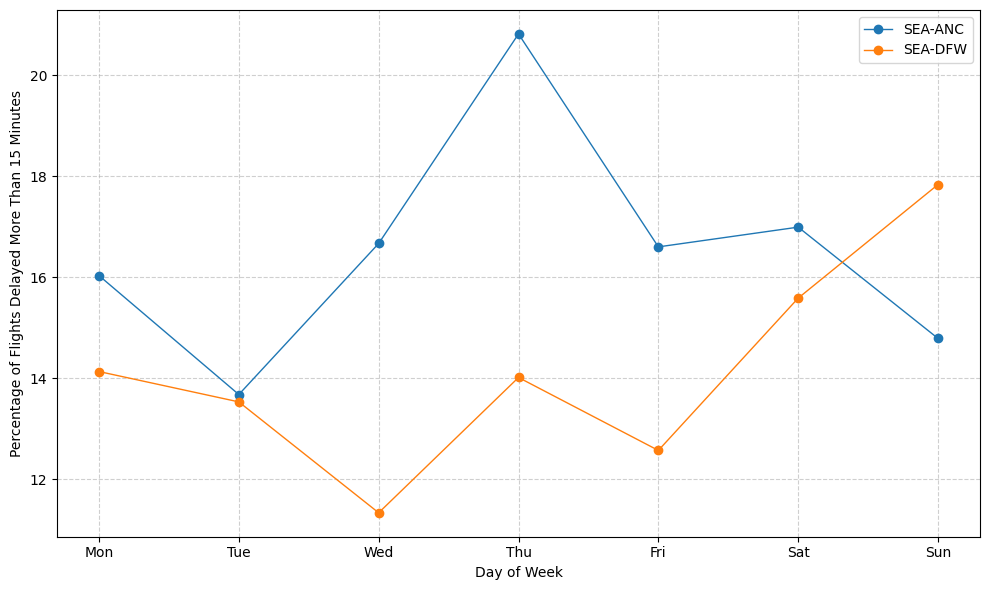

In [11]:
routes = ["SEA-ANC", "SEA-DFW"]

plt.figure(figsize=(10,6))
for route in routes:
    temp = df[df["ORIGIN-DEST"] == route].copy()
    dow = (
        temp.groupby("DAY_NAME")["DEP_DEL15"].mean()
        .reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
        .reset_index()
    )
    plt.plot(dow["DAY_NAME"], dow["DEP_DEL15"]*100,
             marker="o", linewidth=1, label=route)

plt.xlabel("Day of Week")
plt.ylabel("Percentage of Flights Delayed More Than 15 Minutes")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Carrier Performance

In [12]:
df["OP_UNIQUE_CARRIER"].unique()

array(['AA', 'AS', 'B6', 'DL', 'F9', 'G4', 'HA', 'NK', 'OO', 'UA', 'WN',
       'MQ'], dtype=object)

#### Flight Share by Airline

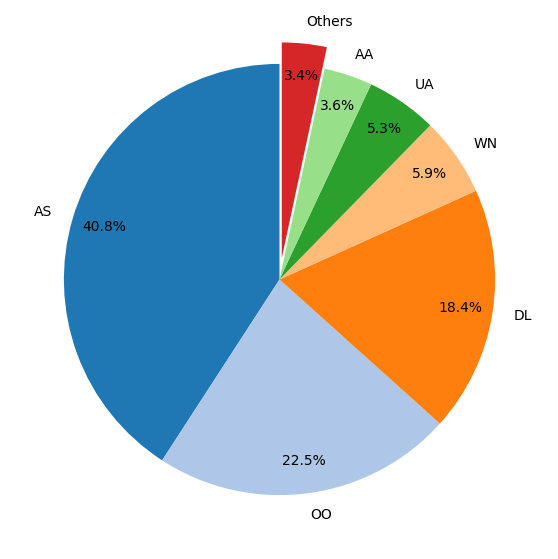

In [13]:
airline_counts = df["OP_UNIQUE_CARRIER"].value_counts()

top6 = airline_counts.head(6)
others = airline_counts.iloc[6:].sum()
airline_pie = pd.concat([top6, pd.Series({"Others": others})])

plt.figure(figsize=(7,7))
colors = plt.cm.tab20.colors
explode = [0]*6 + [0.1]  
plt.pie(airline_pie, labels=airline_pie.index, autopct="%1.1f%%",
        startangle=90, pctdistance=0.85, colors=colors[:len(airline_pie)],
        explode=explode)

plt.show()

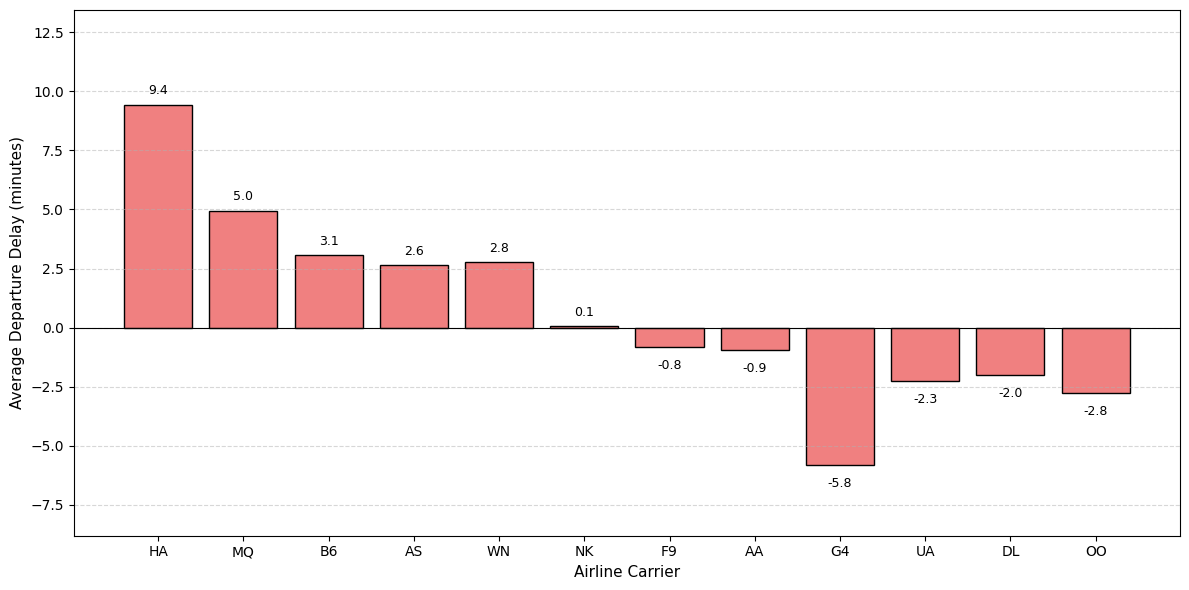

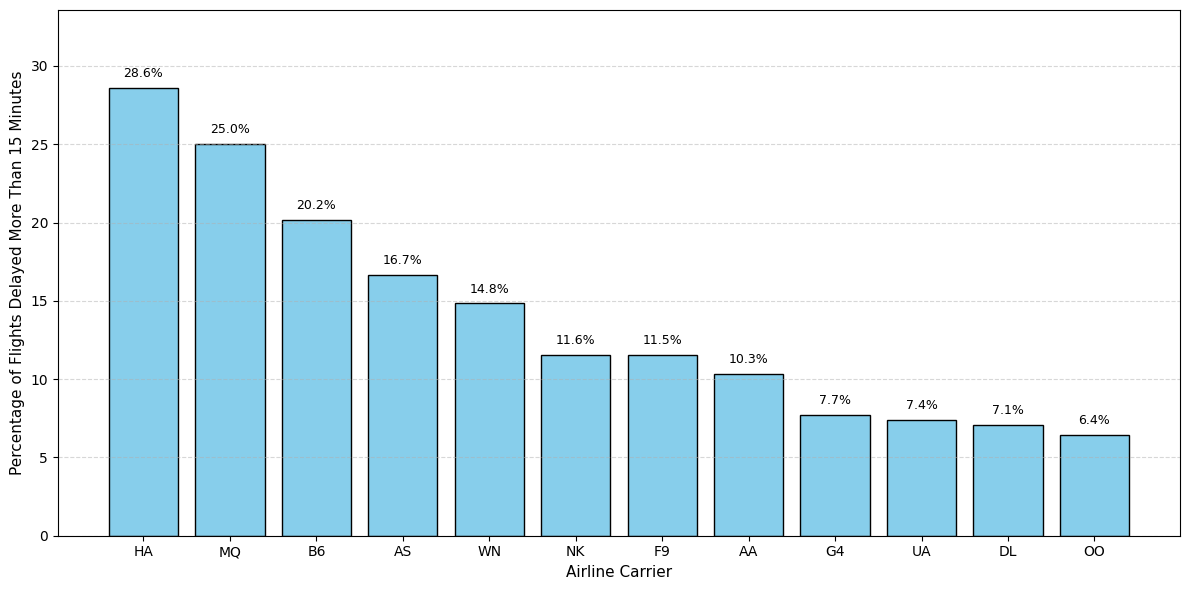

In [14]:
carrier_stats = (
    df.groupby("OP_UNIQUE_CARRIER")
      .agg(
          NUM_FLIGHTS=("DEP_DEL15", "count"),
          PCT_DELAYED_15=("DEP_DEL15", "mean"),
          AVG_DEP_DELAY=("DEP_DELAY", "mean")
      )
      .reset_index()
)

carrier_stats = carrier_stats.sort_values("PCT_DELAYED_15", ascending=False)

# Average Departure Delay by Airline (including early departures)
plt.figure(figsize=(12, 6))
bars = plt.bar(
    carrier_stats["OP_UNIQUE_CARRIER"],
    carrier_stats["AVG_DEP_DELAY"],
    color="lightcoral",
    edgecolor="black"
)

for bar, val in zip(bars, carrier_stats["AVG_DEP_DELAY"]):
    ha = 'center'
    va = 'bottom' if val >= 0 else 'top'
    offset = 0.3 if val >= 0 else -0.5
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + offset,
        f"{val:.1f}",
        ha=ha, va=va, fontsize=9, color="black"
    )

plt.axhline(0, color="black", linewidth=0.8)

plt.xlabel("Airline Carrier", fontsize=11)
plt.ylabel("Average Departure Delay (minutes)", fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.5)

ymin, ymax = carrier_stats["AVG_DEP_DELAY"].min(), carrier_stats["AVG_DEP_DELAY"].max()
plt.ylim(ymin - 3, ymax + 4)

plt.tight_layout()
plt.show()

# Percentage of Flights Delayed More Than 15 Minutes by Airline
plt.figure(figsize=(12, 6))
bars = plt.bar(
    carrier_stats["OP_UNIQUE_CARRIER"],
    carrier_stats["PCT_DELAYED_15"] * 100,
    color="skyblue",
    edgecolor="black"
)

for bar, val in zip(bars, carrier_stats["PCT_DELAYED_15"] * 100):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.5,
        f"{val:.1f}%",
        ha="center", va="bottom", fontsize=9, color="black"
    )

plt.xlabel("Airline Carrier", fontsize=11)
plt.ylabel("Percentage of Flights Delayed More Than 15 Minutes", fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, (carrier_stats["PCT_DELAYED_15"] * 100).max() + 5)

plt.tight_layout()
plt.show()

#### Percentage of Flights Delayed More Than 15 Minutes by Airline

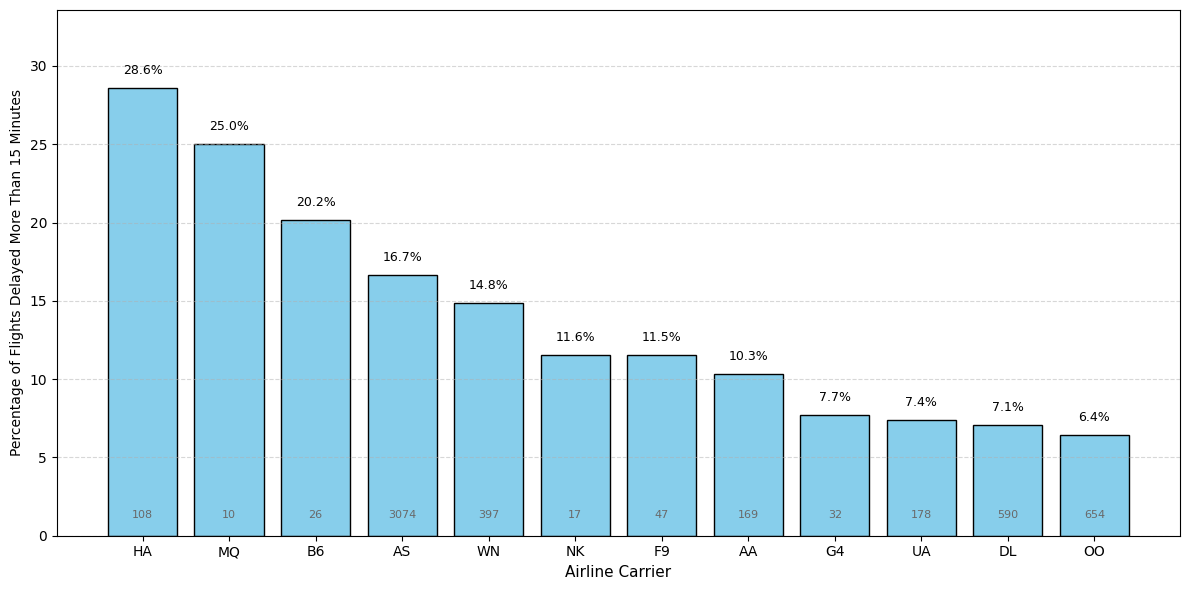

In [15]:
carrier_stats = (
    df.groupby("OP_UNIQUE_CARRIER")
      .agg(
          NUM_FLIGHTS=("DEP_DEL15", "count"),
          NUM_DELAYED=("DEP_DEL15", "sum"),    
          PCT_DELAYED_15=("DEP_DEL15", "mean")  
      )
      .reset_index()
)

carrier_stats = carrier_stats.sort_values("PCT_DELAYED_15", ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    carrier_stats["OP_UNIQUE_CARRIER"],
    carrier_stats["PCT_DELAYED_15"] * 100,
    color="skyblue",
    edgecolor="black"
)

for bar, pct in zip(bars, carrier_stats["PCT_DELAYED_15"] * 100):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        pct + 0.7,  
        f"{pct:.1f}%",
        ha="center", va="bottom", fontsize=9, color="black"
    )

for bar, n in zip(bars, carrier_stats["NUM_DELAYED"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        1.0,   
        f"{int(n)}",
        ha="center", va="bottom", fontsize=8, color="dimgray"
    )

plt.xlabel("Airline Carrier", fontsize=11)
plt.ylabel("Percentage of Flights Delayed More Than 15 Minutes")

plt.grid(axis='y', linestyle='--', alpha=0.5)

ymax = (carrier_stats["PCT_DELAYED_15"] * 100).max()
plt.ylim(0, ymax + 5)

plt.tight_layout()
plt.show()


### Monthly Overview: Optional

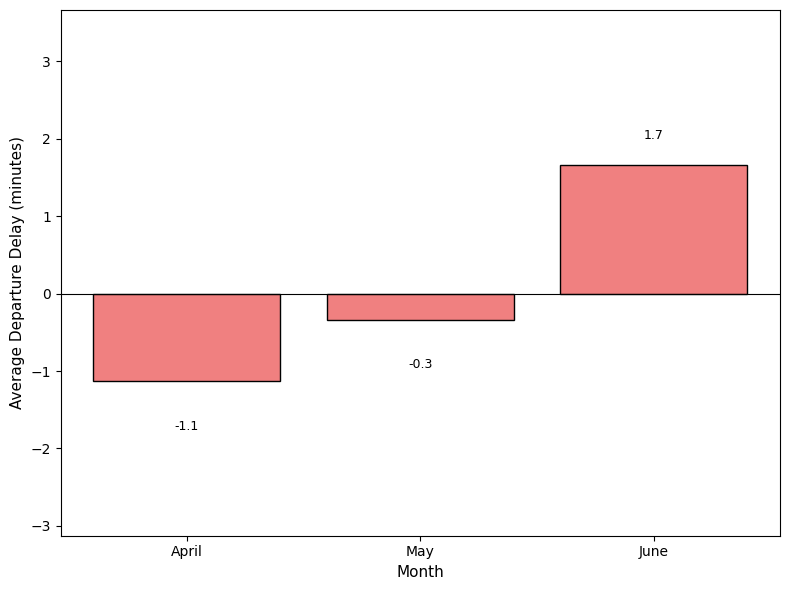

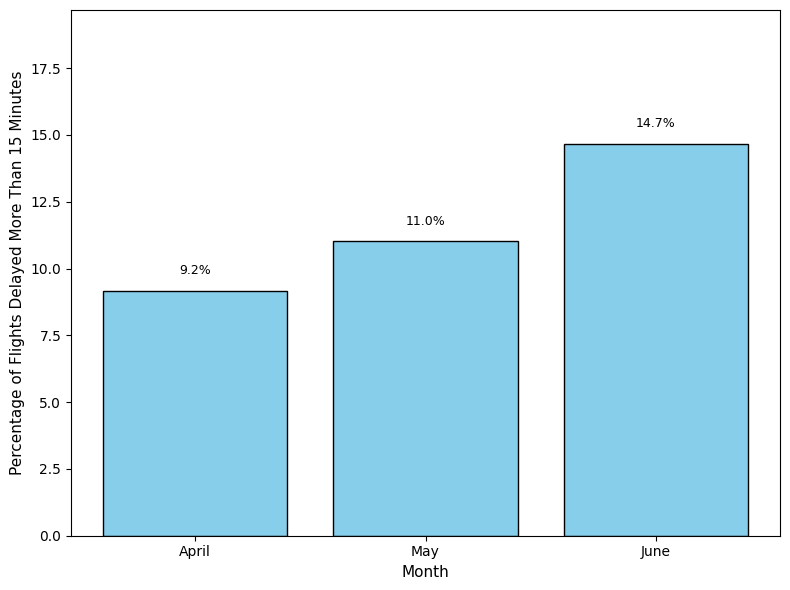

In [16]:
month_stats = (
    df.groupby("MONTH")
      .agg(
          AVG_DEP_DELAY=("DEP_DELAY", "mean"),
          PCT_DELAYED_15=("DEP_DEL15", "mean"),
          NUM_FLIGHTS=("DEP_DELAY", "count")
      )
      .reset_index()
)

# Average Departure Delay by Month
plt.figure(figsize=(8, 6))
bars = plt.bar(
    month_stats["MONTH"],
    month_stats["AVG_DEP_DELAY"],
    color="lightcoral",
    edgecolor="black"
)

for bar, val in zip(bars, month_stats["AVG_DEP_DELAY"]):
    ha = 'center'
    va = 'bottom' if val >= 0 else 'top'
    offset = 0.3 if val >= 0 else -0.5
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + offset,
        f"{val:.1f}",
        ha=ha, va=va, fontsize=9, color="black"
    )

plt.axhline(0, color="black", linewidth=0.8)

plt.xticks(month_stats["MONTH"], ["April", "May", "June"])
plt.xlabel("Month", fontsize=11)
plt.ylabel("Average Departure Delay (minutes)", fontsize=11)
plt.grid(False)

ymin, ymax = month_stats["AVG_DEP_DELAY"].min(), month_stats["AVG_DEP_DELAY"].max()
plt.ylim(ymin - 2, ymax + 2)

plt.tight_layout()
plt.show()

# Percentage of Flights Delayed More Than 15 Minutes by Month
plt.figure(figsize=(8, 6))
bars = plt.bar(
    month_stats["MONTH"],
    month_stats["PCT_DELAYED_15"] * 100,
    color="skyblue",
    edgecolor="black"
)

for bar, val in zip(bars, month_stats["PCT_DELAYED_15"] * 100):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.5,
        f"{val:.1f}%",
        ha="center", va="bottom", fontsize=9, color="black"
    )

plt.xticks(month_stats["MONTH"], ["April", "May", "June"])
plt.xlabel("Month", fontsize=11)
plt.ylabel("Percentage of Flights Delayed More Than 15 Minutes", fontsize=11)
plt.ylim(0, (month_stats["PCT_DELAYED_15"] * 100).max() + 5)

plt.tight_layout()
plt.show()

### Average Departure Delay by Temperature (5°C Bins)

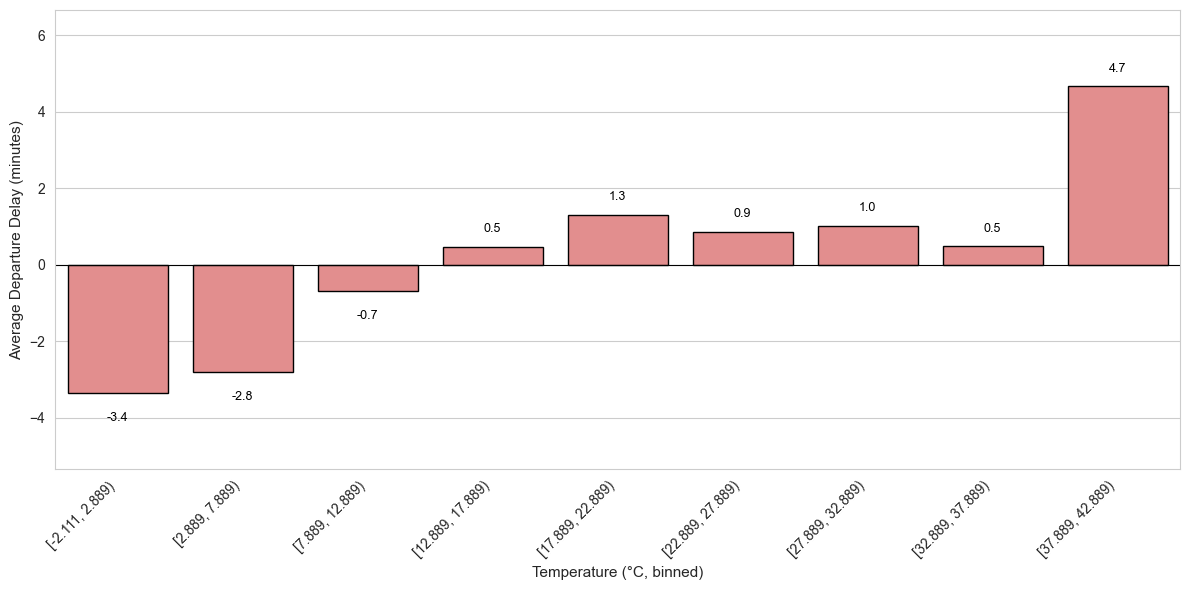

In [17]:
# Average Departure Delay by Temperature (5°C Bins)
df["HourlyDryBulbTemperature_C"] = (df["HourlyDryBulbTemperature"] - 32) * 5 / 9

# Create temperature bins (5°C intervals)
bin_edges = np.arange(
    df["HourlyDryBulbTemperature_C"].min() - 1,
    df["HourlyDryBulbTemperature_C"].max() + 5,
    5
)  
df["TempBin"] = pd.cut(df["HourlyDryBulbTemperature_C"], bins=bin_edges, right=False)

temp_stats = (
    df.groupby("TempBin", observed=True)["DEP_DELAY"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(
    x="TempBin", y="DEP_DELAY",
    data=temp_stats,
    color="lightcoral",
    edgecolor="black"
)

for i, row in temp_stats.iterrows():
    va = "bottom" if row.DEP_DELAY >= 0 else "top"
    offset = 0.3 if row.DEP_DELAY >= 0 else -0.5
    ax.text(
        i,
        row.DEP_DELAY + offset,
        f"{row.DEP_DELAY:.1f}",
        ha="center",
        va=va,
        fontsize=9,
        color="black"
    )

plt.xlabel("Temperature (°C, binned)", fontsize=11)
plt.ylabel("Average Departure Delay (minutes)", fontsize=11)

plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)

ymin, ymax = temp_stats["DEP_DELAY"].min(), temp_stats["DEP_DELAY"].max()
plt.ylim(ymin - 2, ymax + 2)

plt.tight_layout()
plt.show()

### Chắc bỏ thoi, ko bt nữa